In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import h5py
from data_analysis_codes.tools import Ricci_CoGrad_Weyl as RCW_file
from data_analysis_codes.tools import ReadingTools as RRead
from data_analysis_codes.tools import FD as FD_file
simname = 'PlaneWave'

In [2]:
def convergence_order_1d(E1, E2):
    c = abs(E1)/abs(E2)
    print('Convergence order: ', np.mean(np.ma.masked_invalid(np.log(c)/np.log(2))))
def convergence_order_3d(E1, E2):
    E2 = E2[0::2,0::2,0::2]
    c = abs(E1)/abs(E2)
    print('Convergence order: ', np.mean(np.ma.masked_invalid(np.log(c)/np.log(2))))
def convergence_order_4d(E1, E2):
    E2 = E2[2::2,0::2,0::2,0::2]
    E2 = E2[:len(E1)-len(E2)]
    c = abs(E1)/abs(E2)
    print('Convergence order: ', np.mean(np.ma.masked_invalid(np.log(c)/np.log(2))))

In [3]:
L = 20
N = 100
dx = L/N
FD = FD_file.FD_Class(dx, periodic_boundary=False, order6=True)
xyz = np.arange(-L/2, L/2, dx)
x, y, z = np.meshgrid(xyz, xyz, xyz, indexing='ij')
Box_zero = np.zeros([N, N, N])
Box_ones = np.ones([N, N, N])

# 3+1 formulation

In [4]:
t = 1.5

r = 1/2
b = np.sqrt(4*r*(1-r))
beta = 0.0
A = 1.0
B = b*(x+np.log(t))
C = 0.0
gdown = np.array([[(t**2)*Box_ones, Box_zero, Box_zero],
                  [Box_zero, (t**(2*r))*(np.exp(2*r*x))*(A*A*np.exp(beta)+C*C*np.exp(-beta)), (t**(2*r))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))],
                  [Box_zero, (t**(2*r))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta)), (t**(2*r))*(np.exp(2*r*x))*(B*B*np.exp(beta)+A*A*np.exp(-beta))]])

dtA = 0.0
dtB = b/t
dtC = 0.0
Kdown = (-1/2)*np.array([[2*t*Box_ones, Box_zero, Box_zero],
                         [Box_zero, 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*A*np.exp(beta)+C*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(2*A*dtA*np.exp(beta)+2*C*dtC*np.exp(-beta)), 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(dtA*B*np.exp(beta)+A*dtB*np.exp(beta)+dtA*C*np.exp(-beta)+A*dtC*np.exp(-beta))],
                         [Box_zero, 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(dtA*B*np.exp(beta)+A*dtB*np.exp(beta)+dtA*C*np.exp(-beta)+A*dtC*np.exp(-beta)), 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(B*B*np.exp(beta)+A*A*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(2*B*dtB*np.exp(beta)+2*A*dtA*np.exp(-beta))]])

In [7]:
glist = [gdown[0,0], gdown[0,1], gdown[0,2], gdown[1,1], gdown[1,2], gdown[2,2]]
gdet = RRead.det3(glist)
gup = RRead.inv3(glist)
gmixed = np.einsum('ij...,jk...->ik...', gup, gdown)

RCW = RCW_file.Ricci_CoGrad_Weyl_Class(FD)
Gudd = RCW.Christoffel_symbol(gdown, gup)
RicciTdown, RicciS3 = RCW.Ricci_TandS(gup, Gudd)

In [8]:
G        = 1
kappa    = 8*np.pi*G
rho      = 0
pressure = 0
uup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])
gdown4 = np.array([[-Box_ones, Box_zero,   Box_zero,   Box_zero],
                   [Box_zero,  gdown[0,0], gdown[0,1], gdown[0,2]],
                   [Box_zero,  gdown[1,0], gdown[1,1], gdown[1,2]],
                   [Box_zero,  gdown[2,0], gdown[2,1], gdown[2,2]]])
udown = np.einsum('ab...,b...->a...', gdown4, uup)
Tdown4 = (rho+pressure)*np.einsum('a...,b...->ab...',udown,udown)+pressure*gdown4
LCdown = np.zeros([3,3,3, N, N, N])
LCdown[0, 1, 2, :, :, :] = np.sqrt(abs(gdet))
LCdown[1, 2, 0, :, :, :] = np.sqrt(abs(gdet))
LCdown[2, 0, 1, :, :, :] = np.sqrt(abs(gdet))
LCdown[2, 1, 0, :, :, :] = -np.sqrt(abs(gdet))
LCdown[0, 2, 1, :, :, :] = -np.sqrt(abs(gdet))
LCdown[1, 0, 2, :, :, :] = -np.sqrt(abs(gdet))

In [9]:
np.sum(abs(Tdown4))

0.0

# Check Christoffel

In [34]:
print(np.sum(abs(Gudd[0,0,0])))
print(np.sum(abs(Gudd[0,0,1])))
print(np.sum(abs(Gudd[0,0,2])))
print(np.sum(abs(Gudd[1,0,0])))
print(np.sum(abs(Gudd[1,1,1])))
print(np.sum(abs(Gudd[1,1,2])))
print(np.sum(abs(Gudd[1,2,2])))
print(np.sum(abs(Gudd[2,0,0])))
print(np.sum(abs(Gudd[2,1,1])))
print(np.sum(abs(Gudd[2,1,2])))
print(np.sum(abs(Gudd[2,2,2])))

0.0
0.0
0.0
0.0
3.0436599207655667e-09
9.82586354442237e-09
8.597443332899277e-08
0.0
4.5925634667224164e-10
1.396153937154032e-09
1.1133898460672174e-08


<IPython.core.display.Javascript object>


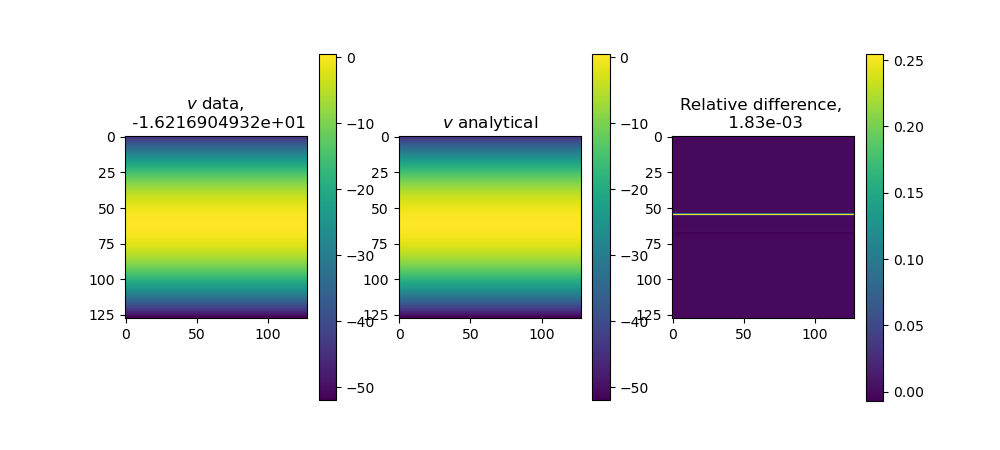

Text(0.5, 1.0, 'Relative difference, \n 1.83e-03')

In [35]:
v = Gudd[0,1,1]
vth = -np.exp(x)/(2*t) #1e-4

var = 1+np.log(t)+x

v = Gudd[0,1,2]
vth = -np.exp(x)*var/(2*t) #1e-4

v = Gudd[0,2,2]
vth = -np.exp(x)*(var**2)/(2*t) #1e-3

v = Gudd[1,0,1]
vth = (2-var)/2 #1e-3

v = Gudd[1,0,2]
vth = (1-np.log(t)*np.log(t)-2*np.log(t)*x-x*x)/2 #1e-3

#v = Gudd[2,0,1]
#vth = Box_ones/2 #1e-3

#v = Gudd[2,0,2]
#vth = var/2 #1e-3

i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(v[:,:,i])
plt.colorbar()
plt.title(r'$v$ data, '+'\n {:.10e}'.format(np.mean(v[:,:,i])))
plt.subplot(132)
plt.imshow(vth[:,:,i])
plt.colorbar()
plt.title(r'$v$ analytical')
plt.subplot(133)
plt.imshow(v[:,:,i]/vth[:,:,i]-1)
plt.colorbar()
plt.title('Relative difference, '+'\n {:.2e}'.format(np.mean(v[:,:,i]/vth[:,:,i]-1)))

<IPython.core.display.Javascript object>


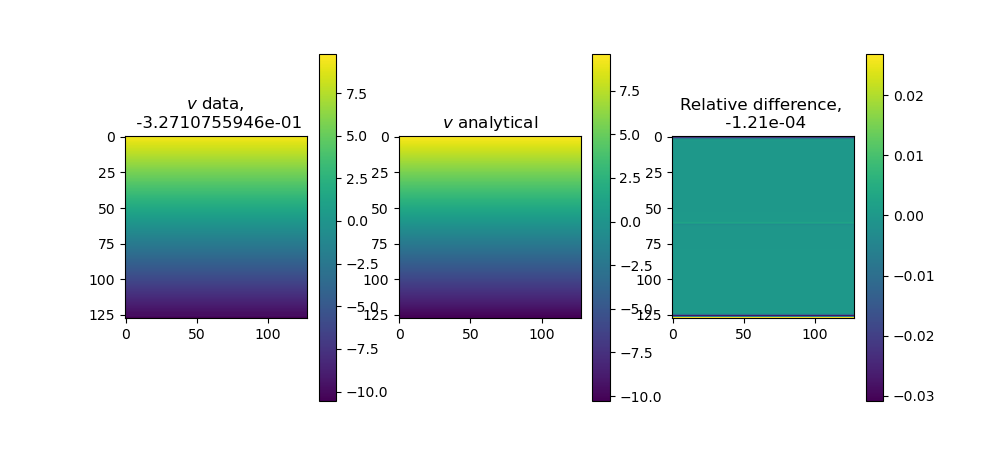

Text(0.5, 1.0, 'Relative difference, \n -1.21e-04')

In [36]:
v = FD.D3x(Gudd[0,1,1])
vth = -np.exp(x)/(2*t) #1e-4

var = 1+np.log(t)+x
dxvar = Box_ones

v = FD.D3x(Gudd[0,1,2])
vth = -(np.exp(x)*var+np.exp(x)*dxvar)/(2*t) #1e-4

v = FD.D3x(Gudd[0,2,2])
vth = -(np.exp(x)*(var**2)+np.exp(x)*(2*dxvar*var))/(2*t) #1e-3

v = FD.D3x(Gudd[1,0,1])
vth = -dxvar/2 #1e-3

v = FD.D3x(Gudd[1,0,2])
vth = (-2*np.log(t)-2*x)/2 #1e-3

#v = FD.D3x(Gudd[2,0,2])
#vth = dxvar/2 #1e-3

i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(v[:,:,i])
plt.colorbar()
plt.title(r'$v$ data, '+'\n {:.10e}'.format(np.mean(v[4:-4,4:-4,i])))
plt.subplot(132)
plt.imshow(vth[:,:,i])
plt.colorbar()
plt.title(r'$v$ analytical')
plt.subplot(133)
diff = v/vth-1
meddiff = np.median(diff)
#for j in range(N-8):
#    for k in range(N-8):
#        for l in range(N-8):
#            diff[j,k,l] = diff[j,k,l] if diff[j,k,l]!=-1 else meddiff
#            if vth[j,k,l]==0.0:
#                diff[j,k,l]=meddiff
plt.imshow(diff[:,:,i])
plt.colorbar()
plt.title('Relative difference, '+'\n {:.2e}'.format(np.median(diff)))

## Check Ricci

In [7]:
RicciS3th = -2/(t*t)
ER64 = RicciS3 - RicciS3th

In [15]:
convergence_order_3d(ER32, ER64)

Convergence order:  3.880438512271671


<IPython.core.display.Javascript object>


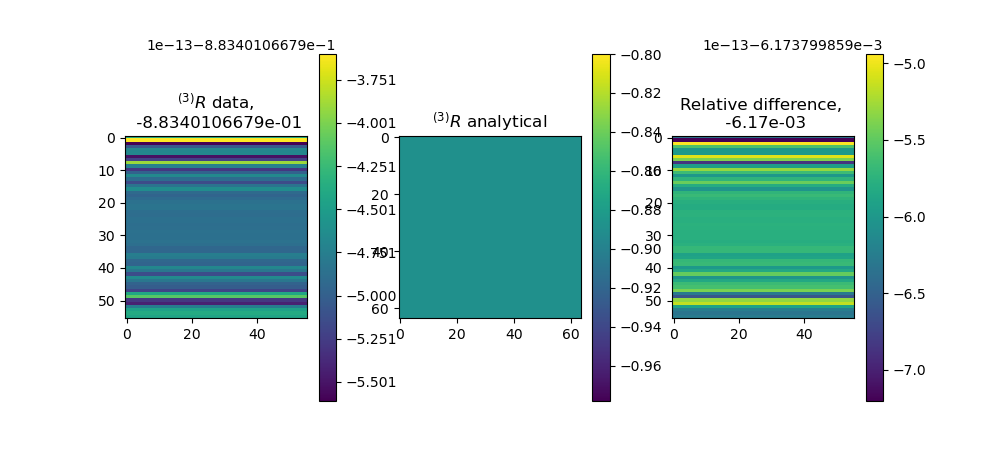

Text(0.5, 1.0, 'Relative difference, \n -6.17e-03')

In [8]:
i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(RicciS3[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'${}^{(3)}R$ data, '+'\n {:.10e}'.format(np.mean(RicciS3[4:-4,4:-4,i])))
plt.subplot(132)
plt.imshow(RicciS3th*Box_ones[:,:,i])
plt.colorbar()
plt.title(r'${}^{(3)}R$ analytical')
plt.subplot(133)
plt.imshow(RicciS3[4:-4,4:-4,i]/RicciS3th-1)
plt.colorbar()
plt.title('Relative difference, '+'\n {:.2e}'.format(np.mean(RicciS3[4:-4,4:-4,i]/RicciS3th-1)))

## Check $B^2$ and $B^T$

In [9]:
nup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])
Bdown, B2, Btrace = RCW.Weyl_B(gdown4, nup, gdown, gup, Gudd, Kdown)
B2th = Box_ones/(2*(t**4))

EB2128 = B2 - B2th
EBT128 = Btrace

In [20]:
convergence_order_3d(EB232, EB264)
convergence_order_3d(EB264, EB2128)
print('--')
convergence_order_3d(EBT32, EBT64)
convergence_order_3d(EBT64, EBT128)

Convergence order:  7.0890565151514515
Convergence order:  6.615689751458442
--
Convergence order:  -0.3530200544829715
Convergence order:  0.002170390179045676


<ipython-input-2-e405fd30ddc3>:6: RuntimeWarning: divide by zero encountered in true_divide
  c = abs(E1)/abs(E2)
<ipython-input-2-e405fd30ddc3>:6: RuntimeWarning: invalid value encountered in true_divide
  c = abs(E1)/abs(E2)
<ipython-input-2-e405fd30ddc3>:7: RuntimeWarning: divide by zero encountered in log
  print('Convergence order: ', np.mean(np.ma.masked_invalid(np.log(c)/np.log(2))))


<IPython.core.display.Javascript object>


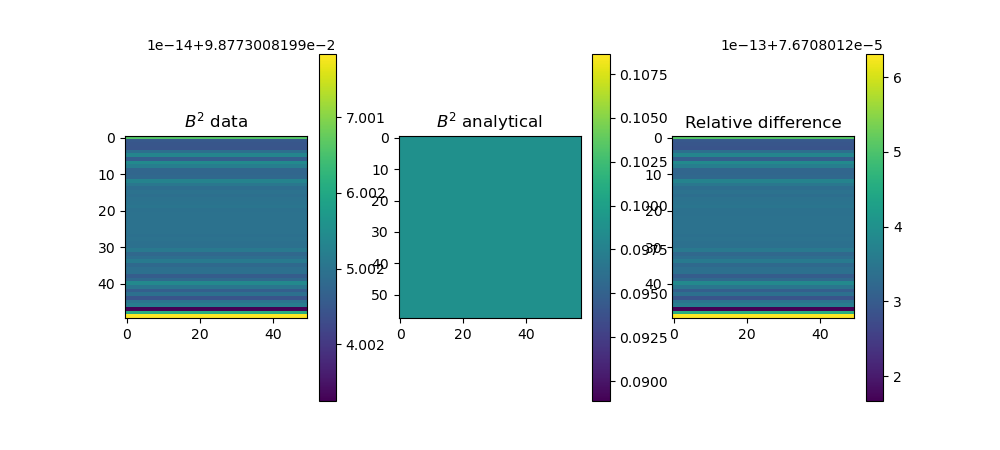

<IPython.core.display.Javascript object>


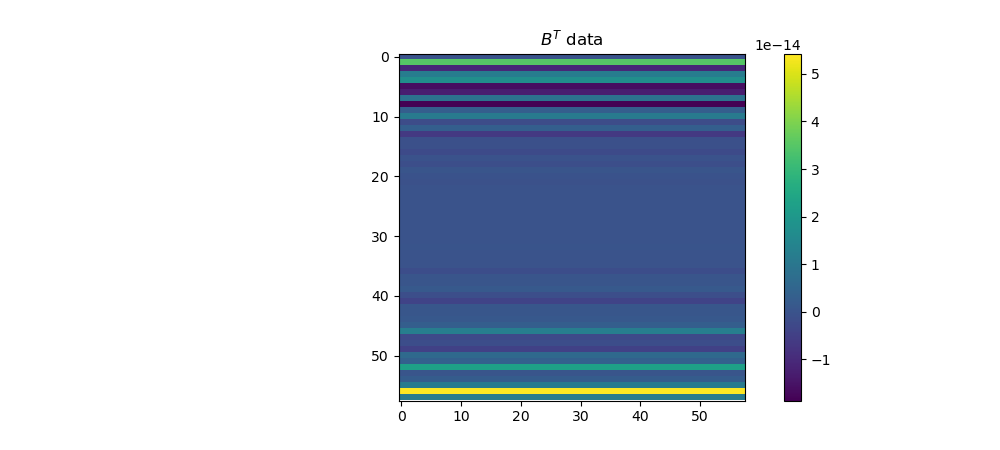

Text(0.5, 1.0, '$B^T$ data')

In [10]:
i = 7
cut = 4
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(B2[cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title(r'$B^2$ data')
plt.subplot(132)
plt.imshow(B2th[:,:,1])
plt.colorbar()
plt.title(r'$B^2$ analytical')
plt.subplot(133)
diff = B2/B2th-1
plt.imshow([[val if val!=-1 else np.median(diff[cut:-cut,cut:-cut,i]) for val in diff[j,cut:-cut,i]] for j in range(cut,N-cut)])
plt.colorbar()
plt.title('Relative difference')

plt.figure(figsize=(10,4.5))
plt.imshow(Btrace[:,:,i])
plt.colorbar()
plt.title(r'$B^T$ data')

## Check $E^2$ and $E^T$

In [11]:
Edown, Eup, E2, Etrace = RCW.Weyl_E(gdown, gup, RicciS3, RicciTdown, Kdown, kappa, rho, 0.0, Tdown4[1:,1:])
E2th = Box_ones/(2*(t**4))

EE264 = E2 - E2th
EET64 = Etrace

In [28]:
convergence_order_3d(EE232, EE264)
convergence_order_3d(EE264, EE2128)
print('--')
convergence_order_3d(EET32, EET64)
convergence_order_3d(EET64, EET128)

Convergence order:  4.17681949245228
Convergence order:  3.963689960694029
--
Convergence order:  -0.1266468262411298
Convergence order:  0.0882394287324225


<ipython-input-2-e405fd30ddc3>:6: RuntimeWarning: divide by zero encountered in true_divide
  c = abs(E1)/abs(E2)
<ipython-input-2-e405fd30ddc3>:7: RuntimeWarning: divide by zero encountered in log
  print('Convergence order: ', np.mean(np.ma.masked_invalid(np.log(c)/np.log(2))))
<ipython-input-2-e405fd30ddc3>:6: RuntimeWarning: invalid value encountered in true_divide
  c = abs(E1)/abs(E2)


<IPython.core.display.Javascript object>


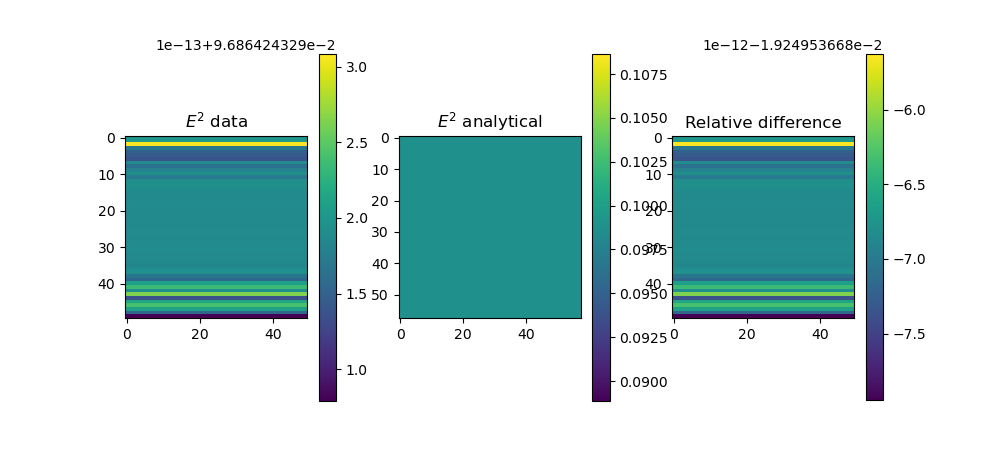

<IPython.core.display.Javascript object>


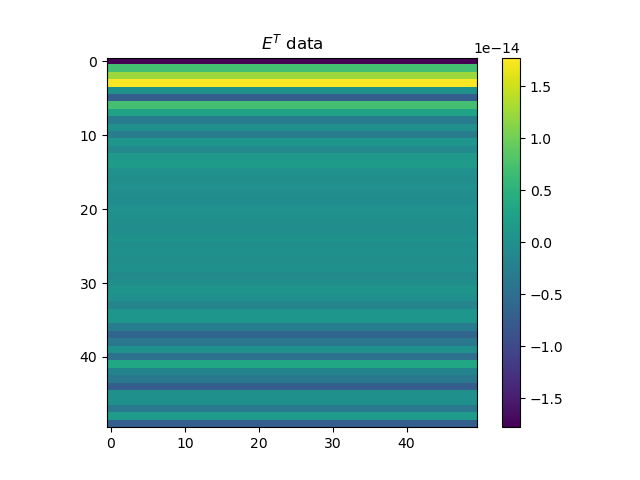

Text(0.5, 1.0, '$E^T$ data')

In [12]:
i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(E2[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'$E^2$ data')
plt.subplot(132)
plt.imshow(E2th[:,:,i])
plt.colorbar()
plt.title(r'$E^2$ analytical')
plt.subplot(133)
plt.imshow(E2[4:-4,4:-4,i]/E2th[4:-4,4:-4,i]-1)
plt.colorbar()
plt.title('Relative difference')

plt.figure()
plt.imshow(Etrace[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'$E^T$ data')

<IPython.core.display.Javascript object>


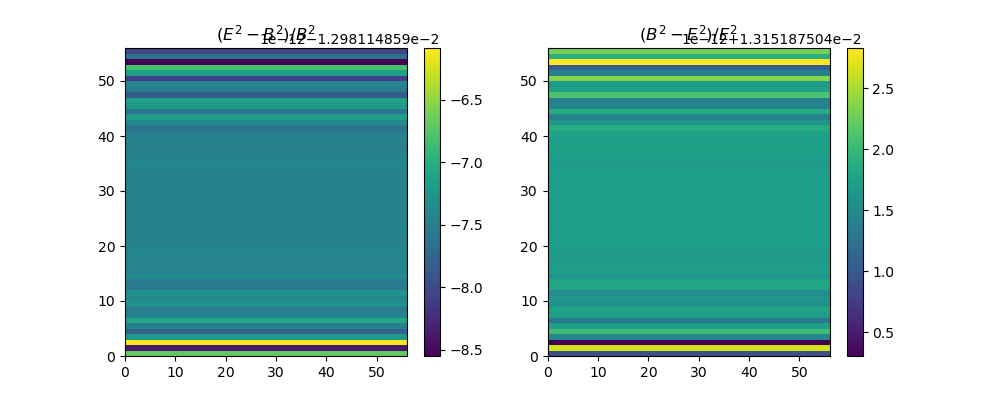

In [12]:
cut = 4
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.pcolor((E2[cut:-cut,cut:-cut,i]-B2[cut:-cut,cut:-cut,i])/B2[cut:-cut,cut:-cut,i])
plt.title(r'$(E^2-B^2)/B^2$')
plt.colorbar()
plt.subplot(122)
plt.pcolor((B2[cut:-cut,cut:-cut,i]-E2[cut:-cut,cut:-cut,i])/E2[cut:-cut,cut:-cut,i])
plt.title(r'$(B^2-E^2)/E^2$')
plt.colorbar()

## Backreaction $Q_{\mathcal{D}}$

In [13]:
K = np.einsum('ab...,ab...->...', Kdown, gup)
Adown = Kdown - gdown*K/3
A2 = np.einsum('ab...,ac...,bd...,cd...->...', Adown, gup, gup, Adown)/2
Q = RCW.Backreaction(gdet[4:-4, 4:-4, 4:-4], K[4:-4, 4:-4, 4:-4], A2[4:-4, 4:-4, 4:-4])

EQ32 = Q

In [14]:
convergence_order_1d(EQ32, EQ64)

Convergence order:  2.0501929624415328e-14


In [15]:
Q

-0.2962962962962969

In [13]:
print(np.mean(np.ma.masked_invalid(abs(B2/E2 - 1))))
print(np.mean(np.ma.masked_invalid(abs(E2/B2 - 1))))

0.001876852282862081
0.001856464777819641


# Geometrical

In [4]:
dt = dx*0.05
tIN = 1.5-8*dt
tF = 1.5+8*dt

In [5]:
for it, t in enumerate(np.arange(tIN, tF, dt)):
    r = 1/2
    b = np.sqrt(4*r*(1-r))
    beta = 0.0
    A = 1.0
    B = b*(x+np.log(t))
    C = 0.0
    gdown = np.array([[(t**2)*Box_ones, Box_zero, Box_zero],
                      [Box_zero, (t**(2*r))*(np.exp(2*r*x))*(A*A*np.exp(beta)+C*C*np.exp(-beta)), (t**(2*r))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))],
                      [Box_zero, (t**(2*r))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta)), (t**(2*r))*(np.exp(2*r*x))*(B*B*np.exp(beta)+A*A*np.exp(-beta))]])

    dtA = 0.0
    dtB = b/t
    dtC = 0.0
    Kdown = (-1/2)*np.array([[2*t*Box_ones, Box_zero, Box_zero],
                             [Box_zero, 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*A*np.exp(beta)+C*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(2*A*dtA*np.exp(beta)+2*C*dtC*np.exp(-beta)), 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(dtA*B*np.exp(beta)+A*dtB*np.exp(beta)+dtA*C*np.exp(-beta)+A*dtC*np.exp(-beta))],
                             [Box_zero, 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(dtA*B*np.exp(beta)+A*dtB*np.exp(beta)+dtA*C*np.exp(-beta)+A*dtC*np.exp(-beta)), 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(B*B*np.exp(beta)+A*A*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(2*B*dtB*np.exp(beta)+2*A*dtA*np.exp(-beta))]])
    fname = '/home/robynm/simulations/'+simname+'_N'+str(N)+'/all_iterations/'+simname+'_it_{:06d}.hdf5'.format(it)
    with h5py.File(fname, 'w') as fnew:
        fnew['gxx it={}'.format(it)] = gdown[0,0]
        fnew['gxy it={}'.format(it)] = gdown[0,1]
        fnew['gxz it={}'.format(it)] = gdown[0,2]
        fnew['gyy it={}'.format(it)] = gdown[1,1]
        fnew['gyz it={}'.format(it)] = gdown[1,2]
        fnew['gzz it={}'.format(it)] = gdown[2,2]
        fnew['kxx it={}'.format(it)] = Kdown[0,0]
        fnew['kxy it={}'.format(it)] = Kdown[0,1]
        fnew['kxz it={}'.format(it)] = Kdown[0,2]
        fnew['kyy it={}'.format(it)] = Kdown[1,1]
        fnew['kyz it={}'.format(it)] = Kdown[1,2]
        fnew['kzz it={}'.format(it)] = Kdown[2,2]

In [5]:
t = 1.5
it = np.argmin(abs(np.arange(tIN, tF, dt)-t))
fname = '/home/robynm/simulations/'+simname+'_N'+str(N)+'/EBWeyl/it={:06d}.hdf5'.format(it)
f = h5py.File(fname, 'r')
f.keys()

<KeysViewHDF5 ['B2', 'Btrace', 'E2', 'Etrace', 'Gudd4', 'RicciS4', 'RiemannTdown4', 'dtdtgdown4', 'dtdxgdown4', 'dtdygdown4', 'dtdzgdown4', 'dtgdown4', 'dxgdown4', 'dygdown4', 'dzgdown4']>

## Check Ricci

In [6]:
RicciS4 = np.array(f['RicciS4'])
RicciS4th = Box_zero
ER64 = RicciS4 - RicciS4th

In [18]:
convergence_order_3d(ER32, ER64)

Convergence order:  3.977677240289312


<IPython.core.display.Javascript object>


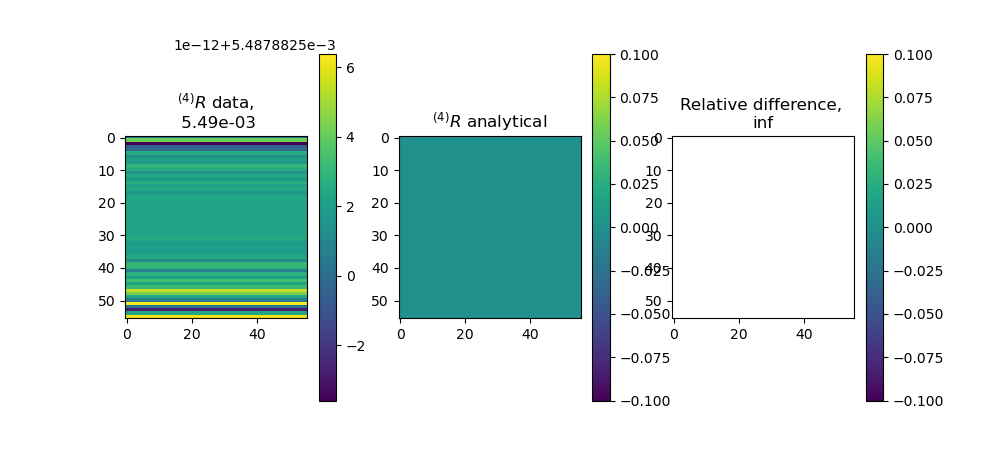

<ipython-input-7-7db566ad0c2f>:12: RuntimeWarning: divide by zero encountered in true_divide
  plt.imshow(RicciS4[4:-4,4:-4,i]/RicciS4th[4:-4,4:-4,i]-1)
<ipython-input-7-7db566ad0c2f>:14: RuntimeWarning: divide by zero encountered in true_divide
  plt.title('Relative difference, \n'+'{:.2e}'.format(np.mean(RicciS4[4:-4,4:-4,i]/RicciS4th[4:-4,4:-4,i]-1)))


Text(0.5, 1.0, 'Relative difference, \ninf')

In [7]:
i = 7
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(RicciS4[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'${}^{(4)}R$ data, '+'\n {:.2e}'.format(np.mean(RicciS4[4:-4,4:-4,i])))
plt.subplot(132)
plt.imshow(RicciS4th[4:-4,4:-4,i])
plt.colorbar()
plt.title(r'${}^{(4)}R$ analytical')
plt.subplot(133)
plt.imshow(RicciS4[4:-4,4:-4,i]/RicciS4th[4:-4,4:-4,i]-1)
plt.colorbar()
plt.title('Relative difference, \n'+'{:.2e}'.format(np.mean(RicciS4[4:-4,4:-4,i]/RicciS4th[4:-4,4:-4,i]-1)))

## Check $B^2$ and $B^T$

In [8]:
B2 = np.array(f['B2'])
B2th = Box_ones/(2*(t**4))
Btrace = np.array(f['Btrace'])
EB264 = B2 - B2th
EBT64 = Btrace

In [21]:
convergence_order_3d(EB232, EB264)
convergence_order_3d(EBT32, EBT64)

Convergence order:  4.000107269554292
Convergence order:  3.982720322654283


<IPython.core.display.Javascript object>


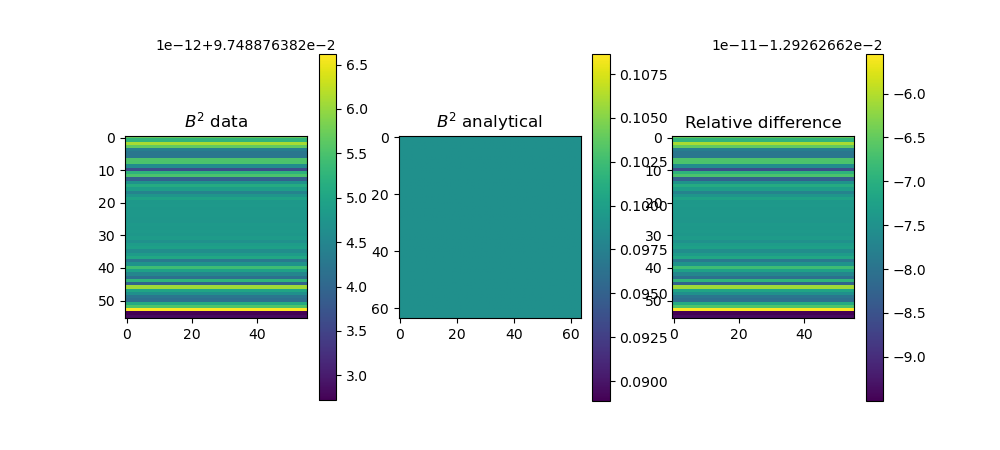

<IPython.core.display.Javascript object>


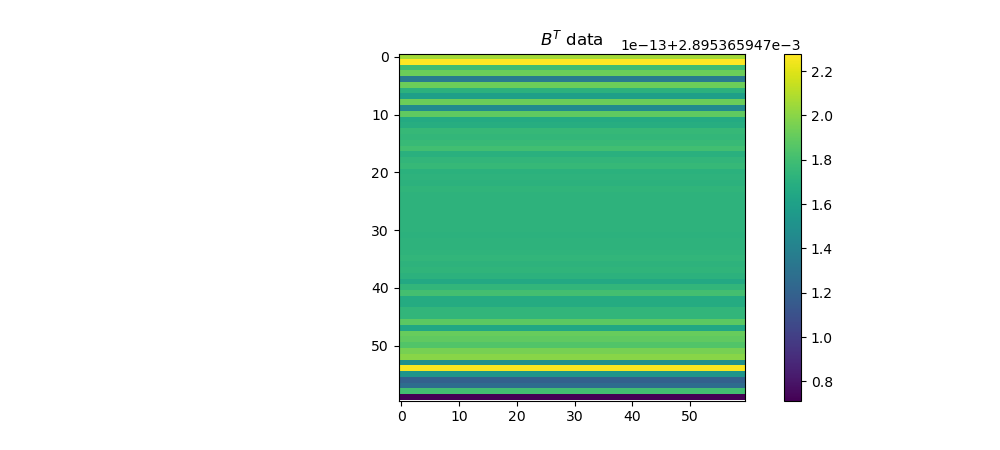

Text(0.5, 1.0, '$B^T$ data')

In [9]:
i = 7
cut = 4
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(B2[cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title(r'$B^2$ data')
plt.subplot(132)
plt.imshow(B2th[:,:,1])
plt.colorbar()
plt.title(r'$B^2$ analytical')
plt.subplot(133)
diff = B2/B2th-1
plt.imshow([[val if val!=-1 else np.median(diff[cut:-cut,cut:-cut,i]) for val in diff[j,cut:-cut,i]] for j in range(cut,N-cut)])
plt.colorbar()
plt.title('Relative difference')

plt.figure(figsize=(10,4.5))
bcut = 2
plt.imshow(Btrace[bcut:-bcut,bcut:-bcut,i])
plt.colorbar()
plt.title(r'$B^T$ data')

# Check Bianchi

<IPython.core.display.Javascript object>


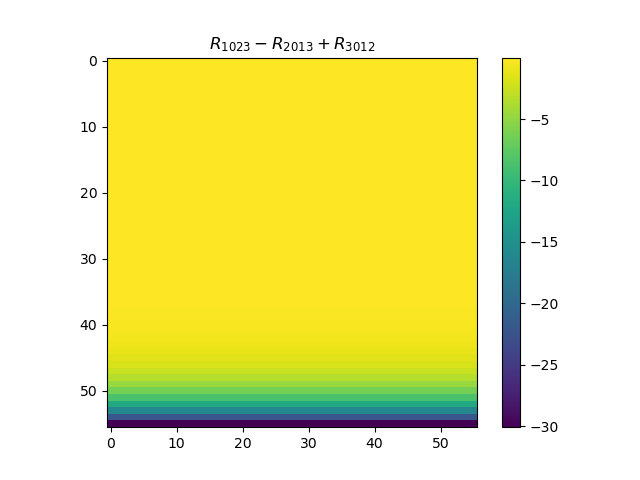

Text(0.5, 1.0, '$R_{1023}-R_{2013}+R_{3012}$')

In [6]:
RiemannTdown4 = np.array(f['RiemannTdown4'])
Bianchi_ID = RiemannTdown4[1,0,2,3]-RiemannTdown4[2,0,1,3]+RiemannTdown4[3,0,1,2]

plt.figure()
i = 7
bcut = 4
plt.imshow(Bianchi_ID[bcut:-bcut,bcut:-bcut,i])
plt.colorbar()
plt.title(r'$R_{1023}-R_{2013}+R_{3012}$')

#plt.figure()
#plt.subplot(131)
#plt.subplot(132)
#plt.subplot(133)

In [7]:
Gudd4 = np.array(f['Gudd4'])
r = 1/2
b = np.sqrt(4*r*(1-r))
beta = 0.0
A = 1.0
B = b*(x+np.log(t))
C = 0.0
gdown4 = np.array([[-Box_ones, Box_zero, Box_zero, Box_zero],
                  [Box_zero, (t**2)*Box_ones, Box_zero, Box_zero],
                  [Box_zero, Box_zero, (t**(2*r))*(np.exp(2*r*x))*(A*A*np.exp(beta)+C*C*np.exp(-beta)), (t**(2*r))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))],
                  [Box_zero, Box_zero, (t**(2*r))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta)), (t**(2*r))*(np.exp(2*r*x))*(B*B*np.exp(beta)+A*A*np.exp(-beta))]])

<IPython.core.display.Javascript object>


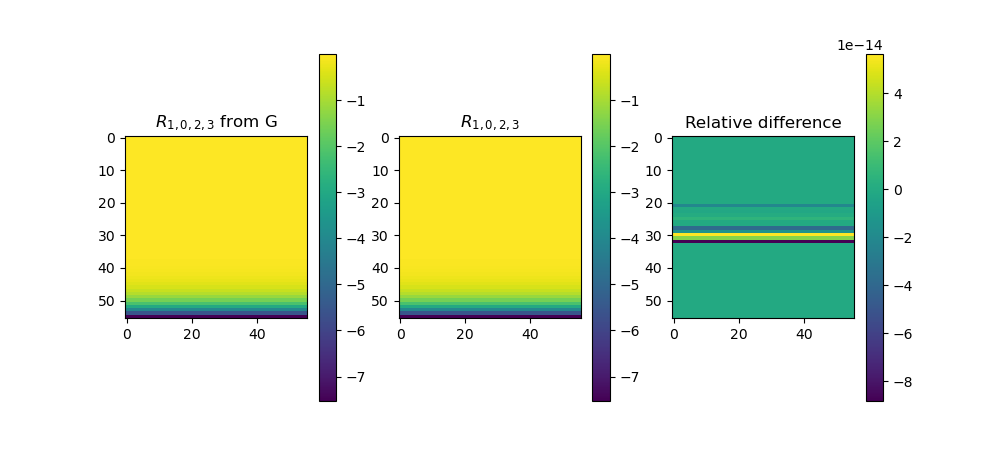

<IPython.core.display.Javascript object>


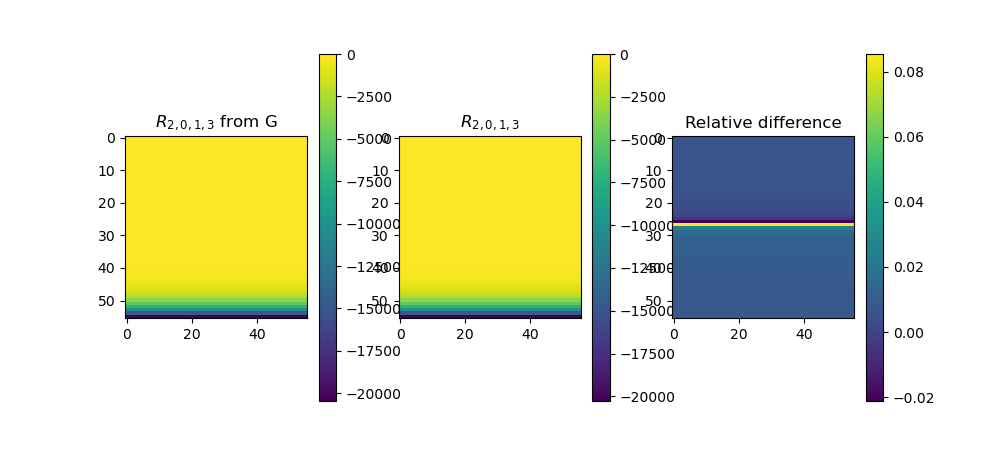

<IPython.core.display.Javascript object>


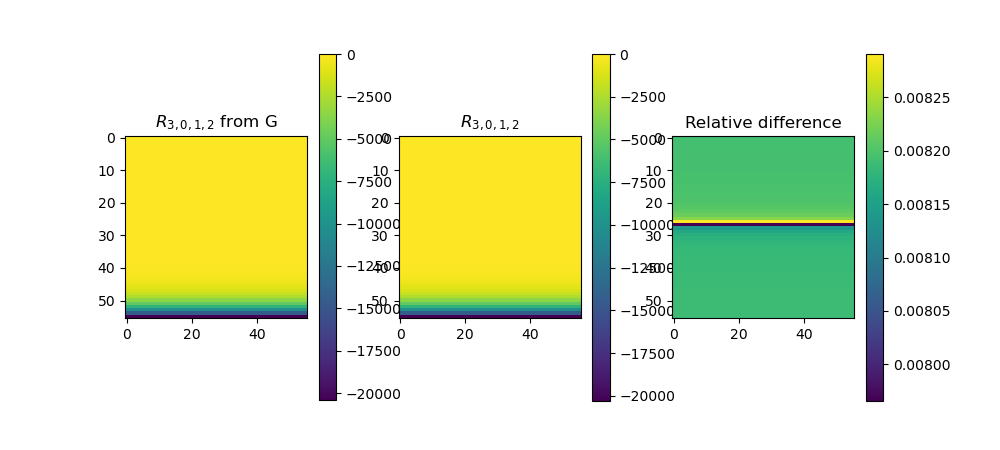

Text(0.5, 1.0, 'Relative difference')

In [18]:
BID = np.copy(Box_zero)
for a in [0,1,2,3]:
    BID +=  gdown4[1,a]*(FD.D3y(Gudd4[a,3,0]) - FD.D3z(Gudd4[a,2,0]))
    for l in [0,1,2,3]:
        BID +=  gdown4[1,a]*(Gudd4[a,2,l]*Gudd4[l,3,0] - Gudd4[a,3,l]*Gudd4[l,2,0])

cut = 4
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(BID[cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title(r'$R_{1,0,2,3}$ from G')
plt.subplot(132)
plt.imshow(RiemannTdown4[1,0,2,3,cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title(r'$R_{1,0,2,3}$')
plt.subplot(133)
diff = BID/RiemannTdown4[1,0,2,3]-1
plt.imshow([[val if val!=-1 else np.median(diff[cut:-cut,cut:-cut,i]) for val in diff[j,cut:-cut,i]] for j in range(cut,N-cut)])
plt.colorbar()
plt.title('Relative difference')

BID = np.copy(Box_zero)
for a in [0,1,2,3]:
    BID += gdown4[2,a]*(FD.D3x(Gudd4[a,3,0]) - FD.D3z(Gudd4[a,1,0]))
    for l in [0,1,2,3]:
        BID += gdown4[2,a]*(Gudd4[a,1,l]*Gudd4[l,3,0] - Gudd4[a,3,l]*Gudd4[l,1,0])

cut = 4
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(BID[cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title(r'$R_{2,0,1,3}$ from G')
plt.subplot(132)
plt.imshow(RiemannTdown4[2,0,1,3,cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title(r'$R_{2,0,1,3}$')
plt.subplot(133)
diff = BID/RiemannTdown4[2,0,1,3]-1
plt.imshow([[val if val!=-1 else np.median(diff[cut:-cut,cut:-cut,i]) for val in diff[j,cut:-cut,i]] for j in range(cut,N-cut)])
plt.colorbar()
plt.title('Relative difference')

BID = np.copy(Box_zero)
for a in [0,1,2,3]:
    BID +=  gdown4[3,a]*(FD.D3x(Gudd4[a,2,0]) - FD.D3y(Gudd4[a,1,0]))
    for l in [0,1,2,3]:
        BID +=  gdown4[3,a]*(Gudd4[a,1,l]*Gudd4[l,2,0] - Gudd4[a,2,l]*Gudd4[l,1,0])

cut = 4
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(BID[cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title(r'$R_{3,0,1,2}$ from G')
plt.subplot(132)
plt.imshow(RiemannTdown4[3,0,1,2,cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title(r'$R_{3,0,1,2}$')
plt.subplot(133)
diff = BID/RiemannTdown4[3,0,1,2]-1
plt.imshow([[val if val!=-1 else np.median(diff[cut:-cut,cut:-cut,i]) for val in diff[j,cut:-cut,i]] for j in range(cut,N-cut)])
plt.colorbar()
plt.title('Relative difference')

## Check $E^2$ and $E^T$

In [10]:
E2 = np.array(f['E2'])
E2th = Box_ones/(2*(t**4))
Etrace = np.array(f['Etrace'])

EE264 = E2 - E2th
EET64 = Etrace

In [24]:
convergence_order_3d(EE232, EE264)
convergence_order_3d(EET32, EET64)

Convergence order:  3.9988395300825994
Convergence order:  0.0665255552249485


<ipython-input-2-d34230f664c5>:3: RuntimeWarning: divide by zero encountered in true_divide
  c = abs(E1)/abs(E2)
<ipython-input-2-d34230f664c5>:4: RuntimeWarning: divide by zero encountered in log
  print('Convergence order: ', np.mean(np.ma.masked_invalid(np.log(c)/np.log(2))))


<IPython.core.display.Javascript object>


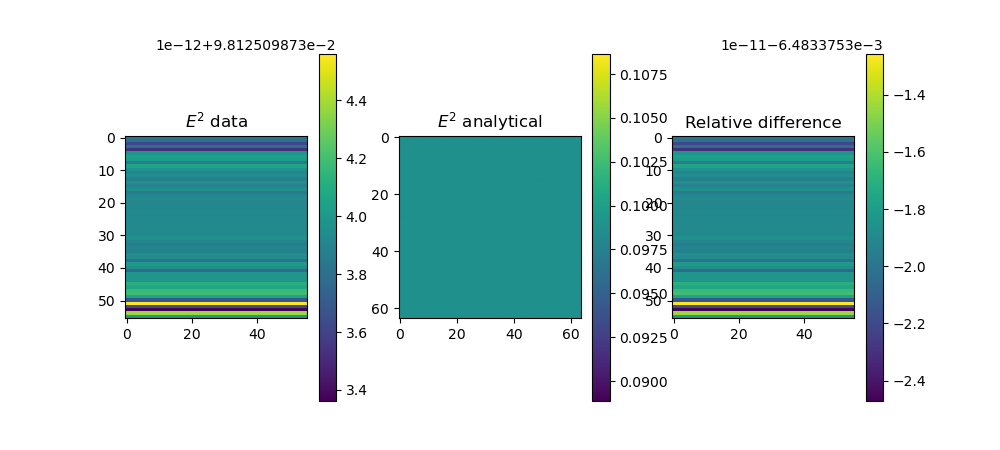

<IPython.core.display.Javascript object>


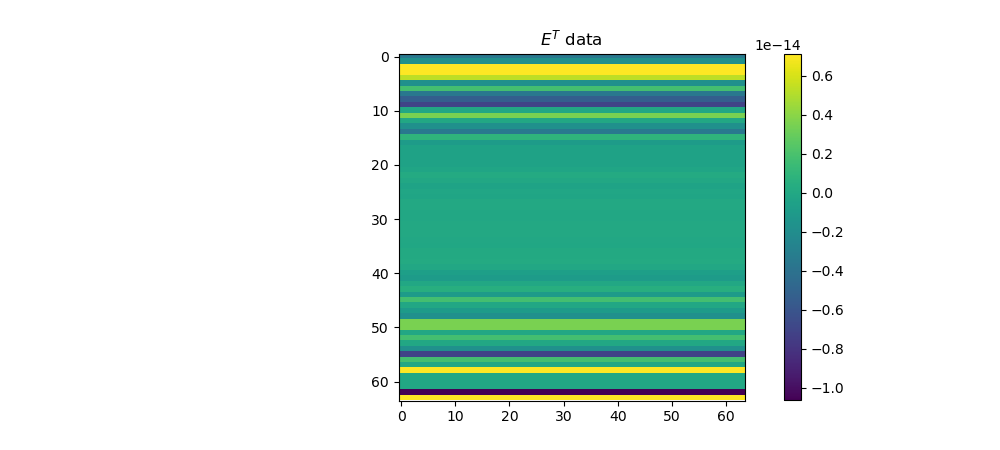

Text(0.5, 1.0, '$E^T$ data')

In [11]:
i = 7
cut = 4
plt.figure(figsize=(10,4.5))
plt.subplot(131)
plt.imshow(E2[cut:-cut,cut:-cut,i])
plt.colorbar()
plt.title(r'$E^2$ data')
plt.subplot(132)
plt.imshow(E2th[:,:,i])
plt.colorbar()
plt.title(r'$E^2$ analytical')
plt.subplot(133)
plt.imshow(E2[cut:-cut,cut:-cut,i]/E2th[cut:-cut,cut:-cut,i]-1)
plt.colorbar()
plt.title('Relative difference')

plt.figure(figsize=(10,4.5))
plt.imshow(Etrace[:,:,i])
plt.colorbar()
plt.title(r'$E^T$ data')

<IPython.core.display.Javascript object>


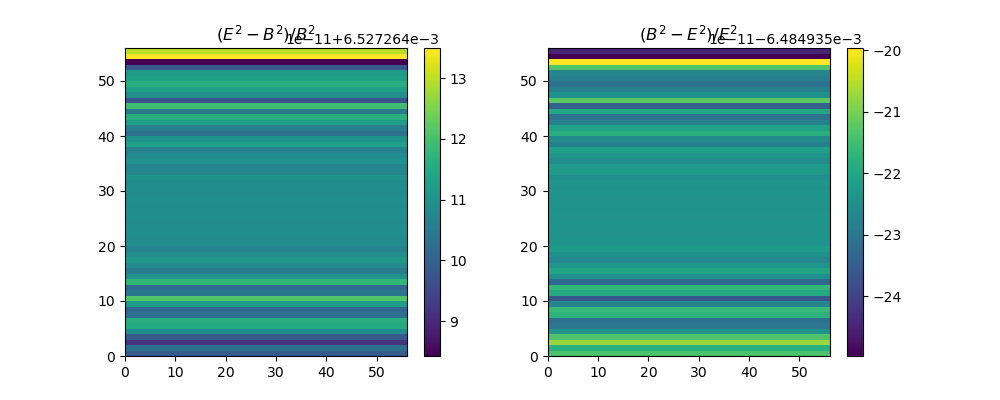

In [16]:
cut = 4
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.pcolor((E2[cut:-cut,cut:-cut,i]-B2[cut:-cut,cut:-cut,i])/B2[cut:-cut,cut:-cut,i])
plt.title(r'$(E^2-B^2)/B^2$')
plt.colorbar()
plt.subplot(122)
plt.pcolor((B2[cut:-cut,cut:-cut,i]-E2[cut:-cut,cut:-cut,i])/E2[cut:-cut,cut:-cut,i])
plt.title(r'$(B^2-E^2)/E^2$')
plt.colorbar()

# Invariants

In [4]:
t = 1.5

r = 1/2
b = np.sqrt(4*r*(1-r))
beta = 0.0
A = 1.0
B = b*(x+np.log(t))
C = 0.0
gdown = np.array([[(t**2)*Box_ones, Box_zero, Box_zero],
                  [Box_zero, (t**(2*r))*(np.exp(2*r*x))*(A*A*np.exp(beta)+C*C*np.exp(-beta)), (t**(2*r))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))],
                  [Box_zero, (t**(2*r))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta)), (t**(2*r))*(np.exp(2*r*x))*(B*B*np.exp(beta)+A*A*np.exp(-beta))]])

dtA = 0.0
dtB = b/t
dtC = 0.0
Kdown = (-1/2)*np.array([[2*t*Box_ones, Box_zero, Box_zero],
                         [Box_zero, 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*A*np.exp(beta)+C*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(2*A*dtA*np.exp(beta)+2*C*dtC*np.exp(-beta)), 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(dtA*B*np.exp(beta)+A*dtB*np.exp(beta)+dtA*C*np.exp(-beta)+A*dtC*np.exp(-beta))],
                         [Box_zero, 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(A*B*np.exp(beta)+A*C*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(dtA*B*np.exp(beta)+A*dtB*np.exp(beta)+dtA*C*np.exp(-beta)+A*dtC*np.exp(-beta)), 2*r*(t**(2*r-1))*(np.exp(2*r*x))*(B*B*np.exp(beta)+A*A*np.exp(-beta))+(t**(2*r))*(np.exp(2*r*x))*(2*B*dtB*np.exp(beta)+2*A*dtA*np.exp(-beta))]])

glist = [gdown[0,0], gdown[0,1], gdown[0,2], gdown[1,1], gdown[1,2], gdown[2,2]]
gdet = RRead.det3(glist)
gup = RRead.inv3(glist)
gmixed = np.einsum('ij...,jk...->ik...', gup, gdown)

RCW = RCW_file.Ricci_CoGrad_Weyl_Class(FD)
Gudd = RCW.Christoffel_symbol(gdown, gup)
RicciTdown, RicciS3 = RCW.Ricci_TandS(gup, Gudd)

G        = 1
kappa    = 8*np.pi*G
rho      = 0
pressure = 0
uup = np.array([Box_ones, Box_zero, Box_zero, Box_zero])
gdown4 = np.array([[-Box_ones, Box_zero,   Box_zero,   Box_zero],
                   [Box_zero,  gdown[0,0], gdown[0,1], gdown[0,2]],
                   [Box_zero,  gdown[1,0], gdown[1,1], gdown[1,2]],
                   [Box_zero,  gdown[2,0], gdown[2,1], gdown[2,2]]])
udown = np.einsum('ab...,b...->a...', gdown4, uup)
Tdown4 = (rho+pressure)*np.einsum('a...,b...->ab...',udown,udown)+pressure*gdown4
LCdown = np.zeros([3,3,3, N, N, N])
LCdown[0, 1, 2, :, :, :] = np.sqrt(abs(gdet))
LCdown[1, 2, 0, :, :, :] = np.sqrt(abs(gdet))
LCdown[2, 0, 1, :, :, :] = np.sqrt(abs(gdet))
LCdown[2, 1, 0, :, :, :] = -np.sqrt(abs(gdet))
LCdown[0, 2, 1, :, :, :] = -np.sqrt(abs(gdet))
LCdown[1, 0, 2, :, :, :] = -np.sqrt(abs(gdet))

LCuud3 = np.einsum('ae...,bf...,efc...->abc...', gup, gup, LCdown)
Bdict = RCW.Weyl_B(gdown, gup, uup, LCuud3, Gudd, Kdown)
Edict = RCW.Weyl_E(gdown, gup, LCuud3, Gudd, RicciS3, RicciTdown, Kdown, kappa, Tdown4[1:,1:])
invar_dict = RCW.Weyl_Invar(gdown, Edict, Bdict)

In [5]:
icut = 6

In [6]:
print('psi0 = ', np.average(abs(invar_dict['psi0'][icut:-icut, icut:-icut, icut:-icut])))
print('psi1 = ', np.average(abs(invar_dict['psi1'][icut:-icut, icut:-icut, icut:-icut])))
print('psi2 = ', np.average(abs(invar_dict['psi2'][icut:-icut, icut:-icut, icut:-icut])))
print('psi3 = ', np.average(abs(invar_dict['psi3'][icut:-icut, icut:-icut, icut:-icut])))
print('psi4 = ', np.average(abs(invar_dict['psi4'][icut:-icut, icut:-icut, icut:-icut])))

psi0 =  3.961440134122698e-06
psi1 =  1.069532751045011e-12
psi2 =  1.1822886824216436e-06
psi3 =  1.069532751045011e-12
psi4 =  3.961440134122698e-06


In [7]:
print('S-1 = ', np.average(abs(invar_dict['S'][icut:-icut, icut:-icut, icut:-icut])-1)) # ill defined as I=J=0
print('I = ', np.average(abs(invar_dict['I'][icut:-icut, icut:-icut, icut:-icut])))
print('J = ', np.average(abs(invar_dict['J'][icut:-icut, icut:-icut, icut:-icut])))
print('K = ', np.average(abs(invar_dict['K'][icut:-icut, icut:-icut, icut:-icut])))
print('LS = ', np.average(abs(invar_dict['LS'][icut:-icut, icut:-icut, icut:-icut])))
print('N = ', np.average(abs(invar_dict['N'][icut:-icut, icut:-icut, icut:-icut])))
print('|E| = ', np.average(abs(invar_dict['|E|'][icut:-icut, icut:-icut, icut:-icut])))
print('|B| = ', np.average(abs(invar_dict['|B|'][icut:-icut, icut:-icut, icut:-icut])))

S-1 =  -0.9999785641573841
I =  1.7606500220498018e-06
J =  2.0816032261520612e-12
K =  2.6576338358712675e-23
LS =  4.683565836662192e-12
N =  2.7630069279261007e-17
|E| =  0.31427476949448324
|B| =  0.3142691675858579


In [8]:
I = np.array(invar_dict['I'])
J = np.array(invar_dict['J'])
Scrit = I*I*I-27*J*J

<IPython.core.display.Javascript object>


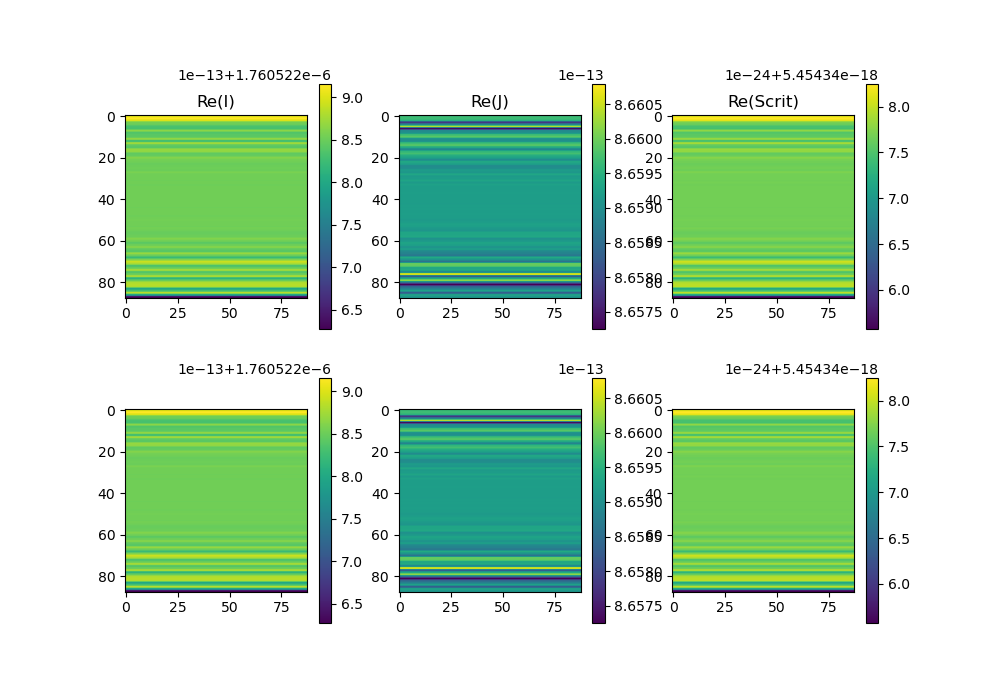

<IPython.core.display.Javascript object>


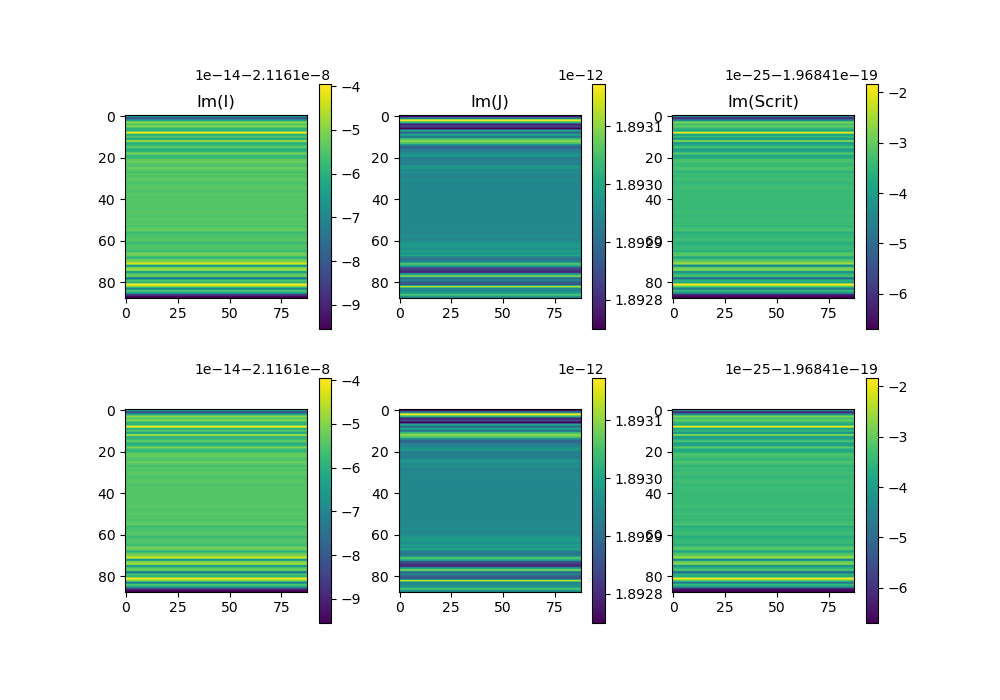

In [9]:
i = 32
plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(np.real(invar_dict['I'][icut:-icut,i,icut:-icut]))
plt.title('Re(I)')
plt.colorbar()
plt.subplot(234)
plt.imshow(np.real(invar_dict['I'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(232)
plt.imshow(np.real(invar_dict['J'][icut:-icut,i,icut:-icut]))
plt.title('Re(J)')
plt.colorbar()
plt.subplot(235)
plt.imshow(np.real(invar_dict['J'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(233)
plt.imshow(np.real(Scrit[icut:-icut,i,icut:-icut]))
plt.title('Re(Scrit)')
plt.colorbar()
plt.subplot(236)
plt.imshow(np.real(Scrit[icut:-icut,icut:-icut,i]))
plt.colorbar()


plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(np.imag(invar_dict['I'][icut:-icut,i,icut:-icut]))
plt.title('Im(I)')
plt.colorbar()
plt.subplot(234)
plt.imshow(np.imag(invar_dict['I'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(232)
plt.imshow(np.imag(invar_dict['J'][icut:-icut,i,icut:-icut]))
plt.title('Im(J)')
plt.colorbar()
plt.subplot(235)
plt.imshow(np.imag(invar_dict['J'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(233)
plt.imshow(np.imag(Scrit[icut:-icut,i,icut:-icut]))
plt.title('Im(Scrit)')
plt.colorbar()
plt.subplot(236)
plt.imshow(np.imag(Scrit[icut:-icut,icut:-icut,i]))
plt.colorbar()

<IPython.core.display.Javascript object>


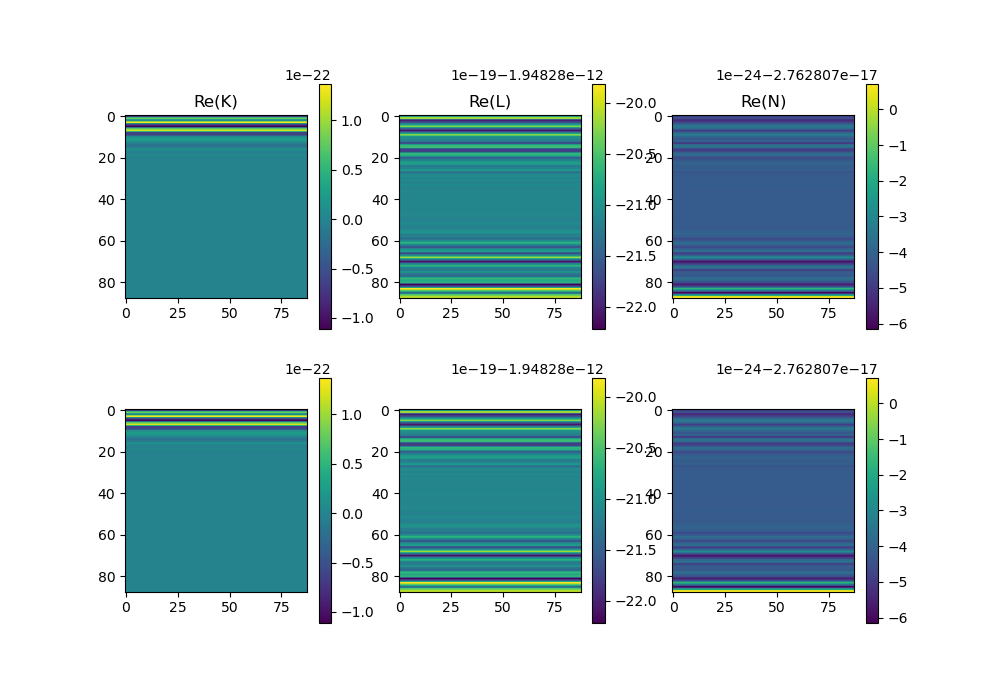

<IPython.core.display.Javascript object>


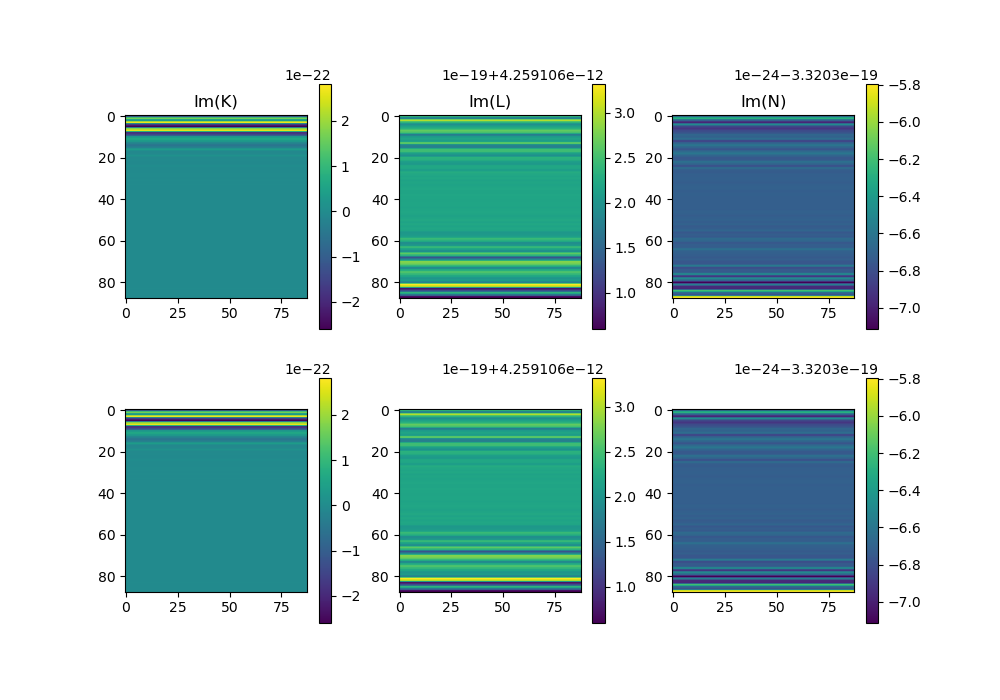

In [10]:
i = 32
plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(np.real(invar_dict['K'][icut:-icut,i,icut:-icut]))
plt.title('Re(K)')
plt.colorbar()
plt.subplot(234)
plt.imshow(np.real(invar_dict['K'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(232)
plt.imshow(np.real(invar_dict['LS'][icut:-icut,i,icut:-icut]))
plt.title('Re(L)')
plt.colorbar()
plt.subplot(235)
plt.imshow(np.real(invar_dict['LS'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(233)
plt.imshow(np.real(invar_dict['N'][icut:-icut,i,icut:-icut]))
plt.title('Re(N)')
plt.colorbar()
plt.subplot(236)
plt.imshow(np.real(invar_dict['N'][icut:-icut,icut:-icut,i]))
plt.colorbar()


plt.figure(figsize=(10,7))
plt.subplot(231)
plt.imshow(np.imag(invar_dict['K'][icut:-icut,i,icut:-icut]))
plt.title('Im(K)')
plt.colorbar()
plt.subplot(234)
plt.imshow(np.imag(invar_dict['K'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(232)
plt.imshow(np.imag(invar_dict['LS'][icut:-icut,i,icut:-icut]))
plt.title('Im(L)')
plt.colorbar()
plt.subplot(235)
plt.imshow(np.imag(invar_dict['LS'][icut:-icut,icut:-icut,i]))
plt.colorbar()

plt.subplot(233)
plt.imshow(np.imag(invar_dict['N'][icut:-icut,i,icut:-icut]))
plt.title('Im(N)')
plt.colorbar()
plt.subplot(236)
plt.imshow(np.imag(invar_dict['N'][icut:-icut,icut:-icut,i]))
plt.colorbar()

# Type N